# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [11]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from torch.utils.data import WeightedRandomSampler

from IPython.display import clear_output

%matplotlib inline

In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 2

In [13]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, 
                 p1 = 0.2, p2 = 0.2, alpha = 7, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        #data.sample()
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
        self._classes = len(labels) if read_labels else 30
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

        self.p1 = p1
        self.p2 = p2
        self.alpha = alpha

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        p1 = self.p1
        p2 = self.p2
        alpha = self.alpha
        if np.random.rand() < p1:
            choice = np.random.choice(range(feats.shape[0]), feats.shape[0]//alpha)        
            feats[choice, :] *= 0
        if np.random.rand() < p2:
            choice = np.random.choice(range(feats.shape[1]), feats.shape[1]//alpha)        
            feats[:, choice] *= 0
        return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


### Feats part

In [14]:
class LogMelSpectrogram(nn.Module):
    def __init__(self, n_fft=2048, hop_length=512, n_mels=60, left = 0.01, right = 1., trigger = True):
        super(LogMelSpectrogram, self).__init__()

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.left = left
        self.right = right
        self.trigger = trigger

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
                n_fft=self.n_fft,
                hop_length=self.hop_length,
                n_mels=self.n_mels,
            )
        
    def forward(self, x):
        # x должен быть тензором формы (batch_size, num_channels, num_samples)
        mel_spectrogram = self.mel_transform(x)
        left = self.left
        right = self.right
        eps = 0.1
        log_mel_spectrogram = torch.log(mel_spectrogram + eps)  # Добавляем маленькое значение для избежания логарифма нуля
        return log_mel_spectrogram

FEATS = 40
BATCH_SIZE = 256

transform = LogMelSpectrogram(n_mels = FEATS)

trainset = Dataset('train', '/kaggle/input/sound-dataset/ml_trains/ml_trains_data', transform, p1 = 0.0, p2 = 0.0)
testset = Dataset('eval',  '/kaggle/input/sound-dataset/ml_trains/ml_trains_data', transform, read_labels = False, p1 = 0, p2 = 0)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

LENGTH = trainset.__getitem__(0)[0].shape[-1]

def collate_fn(batch, max_length = LENGTH):
    #max_length = max(LENGTH, max(item[0].shape[1] for item in batch))
    #print(max_length)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

In [6]:
def collate_fn(batch, max_length = LENGTH):
    #max_length = max(LENGTH, max(item[0].shape[1] for item in batch))
    #print(max_length)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

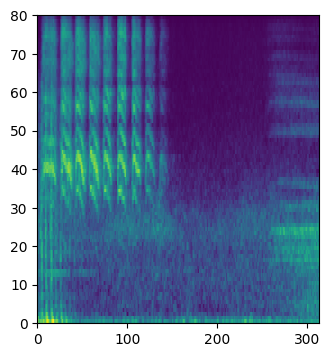

In [50]:
n = 16
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(trainset.__getitem__(n)[0]) 


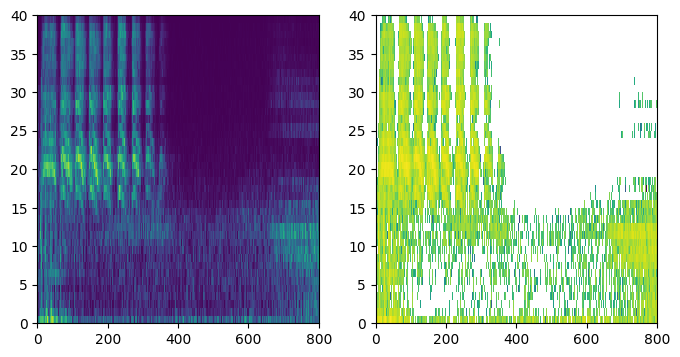

In [22]:
n = 16
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(trainset.__getitem__(n)[0]) 
plt.subplot(1, 2, 2)
plt.pcolormesh(torch.log(trainset.__getitem__(n)[0] + 1))
plt.show()


In [54]:
SAMPLE_WEIGHTS = torch.tensor([0.02688872, 0.03006228, 0.0329624 , 0.04225949, 0.03209398,
       0.0318749 , 0.03564636, 0.03519854, 0.03280801, 0.03359477,
       0.03592057, 0.03412673, 0.04175565, 0.03745727, 0.01833641,
       0.03686584, 0.03615231, 0.03437796, 0.03652939, 0.0362928 ,
       0.02847362, 0.03720855, 0.03781112, 0.01751128, 0.03205726,
       0.03596668, 0.02528704, 0.03116579, 0.03610572, 0.03720855])
SAMPLER = WeightedRandomSampler(SAMPLE_WEIGHTS, len(SAMPLE_WEIGHTS))

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [19]:
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    targets = np.array([item[0] for item in items])
    predictions = np.array([item[1] for item in items])
    s = 0
    for c in range(classes):
        s += np.sum((targets == c) * (predictions == c)) / np.sum(targets == c)
    return 1/classes * s
    # <YOUR CODE IS HERE>

In [18]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

In [10]:
data = trainset

loader = torch_data.DataLoader(
        data,
        batch_size=32,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
for x in loader:
    print(x[0].shape)
    break

input_projection = nn.Linear(801, 512)
src = torch.rand(64, 40, 801)
out = input_projection(src)
print(out.shape)
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = out
out = transformer_encoder(src)
print(out.shape)

HEIGHT = x[0].shape[2]

torch.Size([32, 40, 626])
torch.Size([64, 40, 512])
torch.Size([64, 40, 512])


### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, n_feats = FEATS, num_classes = N_CLASSES, seq_length = LENGTH,
                 d1 = 8, d2 = 8, d3 = 8,
                 f1 = 3, f2 = 4, pad1 = 1, pad2 = 2,
                 d_fc = 128):
        super(CNN, self).__init__()
        
        # Свёрточные слои
        self.conv1 = nn.Conv2d(1, d1, kernel_size=(f1, f2), padding=(pad1, pad2))  # Измените количество каналов на 1 (вход)
        self.bn1 = nn.BatchNorm2d(d1)
        self.conv2 = nn.Conv2d(d1, d2, kernel_size=(f1, f2), padding=(pad1, pad2))
        self.bn2 = nn.BatchNorm2d(d2)
        self.conv3 = nn.Conv2d(d2, d3, kernel_size=(f1, f2), padding=(pad1, pad2))
        self.bn3 = nn.BatchNorm2d(d3)

        # Полносвязные слои
        
        self.fc1 = nn.Linear(d3 * (n_feats) * ( seq_length // 8 + int(seq_length % 8 != 0)), d_fc)  # Измените размерность в соответствии с выходом свёрточных слоёв
        self.fc2 = nn.Linear(d_fc, num_classes)

        # Пулинг
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))

    def forward(self, x):
        # x имеет размерность (batch_size, n_feats, seq_length)
        x = x.unsqueeze(1)  # Добавляем канал: (batch_size, 1, n_feats, seq_length)

        # Прямой проход через свёрточные слои и пулинг
        #print(x.shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        #print(x.shape)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        #print(x.shape)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #print(x.shape)

        # Перепутываем размерности для полносвязного слоя
        x = x.view(x.size(0), -1)  # (batch_size, -1)

        # Прямой проход через полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

if __name__ == "__main__":
    batch_size = 128
    n_feats = FEATS   # Количество признаков
    seq_length = 801  # Длина последовательности
    num_classes = 30   # Количество классов для классификации

    model = CNN(n_feats=n_feats, num_classes=num_classes, seq_length=seq_length)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(total_params)
    input_tensor = torch.randn(batch_size, n_feats, seq_length)  # Входной тензор
    output = model(input_tensor)

    print(output.shape)  # Ожидаемый выход: (BATCH_SIZE, NUM_CLASSES)


4142662
torch.Size([128, 30])


In [70]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True,
    sampler = None
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        sampler = None
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
        print(loss.item())
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    trainset,
    batch_size: int = 256,
    epochs: int = 10,
    name = 'params',
    start_epoch = 0,
    test_size = 0.1,
    sampler = None,
    eval = False

):
    train_data, val_data = torch.utils.data.random_split(trainset, (1 - test_size, test_size), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(start_epoch, epochs):
        if not eval: 
            train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size, sampler = sampler)
            val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False, sampler = sampler)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            clear_output()
            fig, axis = plt.subplots(1, 2, figsize=(15, 7))
            axis[0].plot(np.arange(1, epoch + 2 - start_epoch), train_losses, label='train')
            axis[0].plot(np.arange(1, epoch + 2 - start_epoch), val_losses, label='val')
            axis[1].plot(np.arange(1, epoch + 2 - start_epoch), train_accs, label='train')
            axis[1].plot(np.arange(1, epoch + 2 - start_epoch), val_accs, label='val')
            axis[0].set(xlabel='epoch', ylabel='CE Loss')
            axis[1].set(xlabel='epoch', ylabel='Accuracy')
            fig.legend()
            plt.show()
            print(f'Epoch {epoch + 1}.')
            print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
            print(f'Test loss {val_loss}. Test accuracy {val_acc}')
    
            torch.save(model.state_dict(), name + str(epoch) + '.pt')
        else:
            val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False, sampler = sampler)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            clear_output()
            fig, axis = plt.subplots(1, 2, figsize=(15, 7))
            axis[0].plot(np.arange(1, epoch + 2 - start_epoch), val_losses, label='val')
            axis[1].plot(np.arange(1, epoch + 2 - start_epoch), val_accs, label='val')
            axis[0].set(xlabel='epoch', ylabel='CE Loss')
            axis[1].set(xlabel='epoch', ylabel='Accuracy')
            fig.legend()
            plt.show()
            print(f'Epoch {epoch + 1}.')
            print(f'Test loss {val_loss}. Test accuracy {val_acc}')
            break


In [30]:
model = Conformer().to('cpu')
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')
opt = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0.0)

Total number of parameters: 1430414


In [ ]:
#LSTM29
#/kaggle/working/conf-very-last6.pt
#/kaggle/working/conf-very-last8.pt

In [43]:
opt = optim.Adam(model.parameters(), lr = 3e-4)

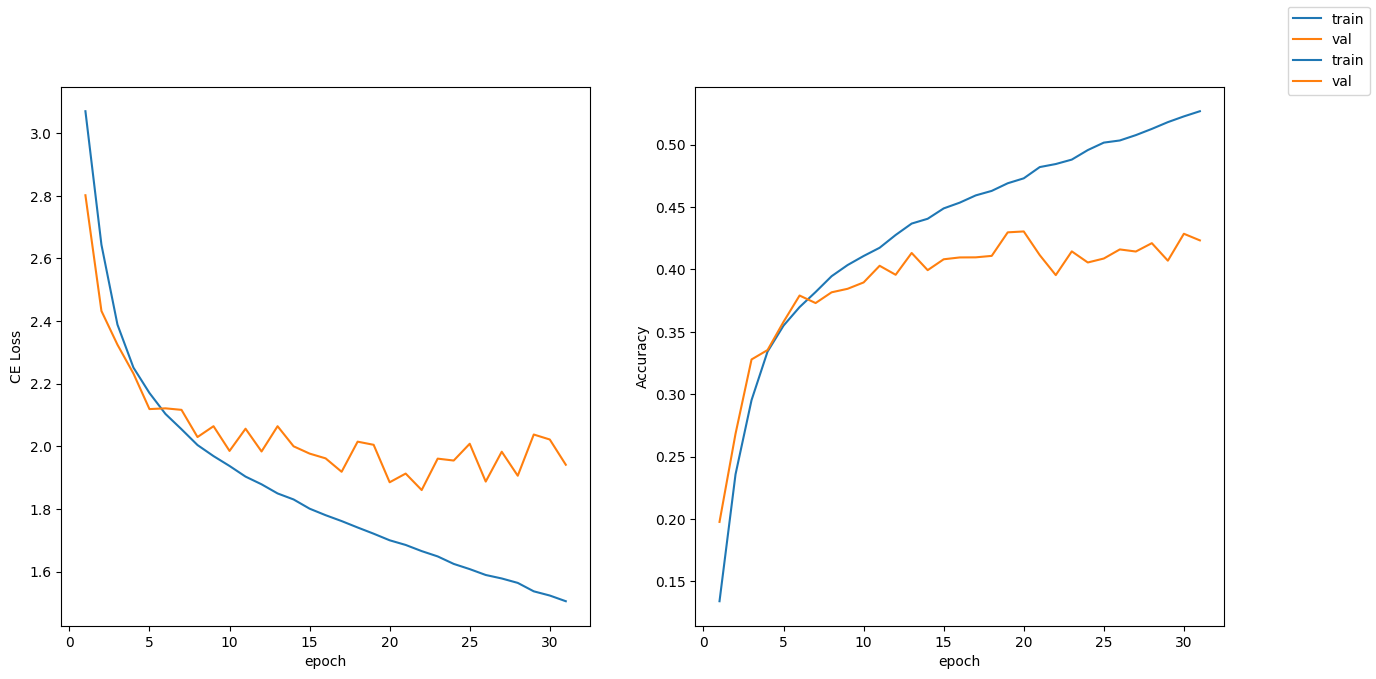

Epoch 31.
Train loss 1.5051036245968876. Train accuracy 0.526792021357814.
Test loss 1.9409212470054626. Test accuracy 0.4232566284981013


  1%|          | 1/98 [00:02<04:28,  2.77s/it]

1.3834105730056763
1.537717342376709


  3%|▎         | 3/98 [00:05<02:38,  1.67s/it]

1.4758957624435425
1.323812484741211


  5%|▌         | 5/98 [00:07<02:15,  1.45s/it]

1.4770466089248657
1.5984078645706177


  7%|▋         | 7/98 [00:10<02:05,  1.38s/it]

1.4107019901275635
1.513239860534668


  9%|▉         | 9/98 [00:13<02:00,  1.36s/it]

1.4357705116271973
1.377239465713501


 11%|█         | 11/98 [00:15<01:55,  1.32s/it]

1.5608433485031128
1.490254521369934


 13%|█▎        | 13/98 [00:18<01:56,  1.37s/it]

1.3395923376083374
1.4755468368530273


 15%|█▌        | 15/98 [00:20<01:50,  1.33s/it]

1.4607170820236206
1.464782476425171


 17%|█▋        | 17/98 [00:23<01:46,  1.32s/it]

1.3981516361236572
1.4810460805892944


 19%|█▉        | 19/98 [00:26<01:43,  1.31s/it]

1.5008689165115356
1.362051010131836


 21%|██▏       | 21/98 [00:28<01:39,  1.29s/it]

1.5793205499649048
1.3901759386062622


 23%|██▎       | 23/98 [00:31<01:36,  1.28s/it]

1.5234642028808594


 24%|██▍       | 24/98 [00:31<01:20,  1.09s/it]

1.4303687810897827


 27%|██▋       | 26/98 [00:33<01:18,  1.09s/it]

1.487335443496704
1.545801043510437


 29%|██▊       | 28/98 [00:36<01:16,  1.09s/it]

1.548015832901001
1.437307357788086


 31%|███       | 30/98 [00:39<01:15,  1.10s/it]

1.524943470954895
1.521169662475586


 32%|███▏      | 31/98 [00:41<01:39,  1.49s/it]

1.483808159828186


 33%|███▎      | 32/98 [00:41<01:14,  1.12s/it]

1.4898687601089478


 35%|███▍      | 34/98 [00:44<01:11,  1.11s/it]

1.3471759557724
1.585188865661621


 36%|███▌      | 35/98 [00:46<01:34,  1.49s/it]

1.3624664545059204


 37%|███▋      | 36/98 [00:47<01:09,  1.12s/it]

1.5544630289077759


 38%|███▊      | 37/98 [00:49<01:37,  1.59s/it]

1.4504870176315308


 39%|███▉      | 38/98 [00:50<01:11,  1.20s/it]

1.464430809020996


 40%|███▉      | 39/98 [00:52<01:30,  1.54s/it]

1.4857447147369385


 41%|████      | 40/98 [00:52<01:08,  1.18s/it]

1.4200977087020874


 42%|████▏     | 41/98 [00:54<01:25,  1.50s/it]

1.4205303192138672


 43%|████▎     | 42/98 [00:55<01:03,  1.14s/it]

1.5870983600616455


 44%|████▍     | 43/98 [00:57<01:20,  1.46s/it]

1.5319067239761353


 45%|████▍     | 44/98 [00:57<01:00,  1.12s/it]

1.5321022272109985


 46%|████▌     | 45/98 [01:00<01:18,  1.48s/it]

1.4099056720733643


 47%|████▋     | 46/98 [01:00<00:58,  1.13s/it]

1.4824851751327515


 48%|████▊     | 47/98 [01:02<01:15,  1.49s/it]

1.5138951539993286


 49%|████▉     | 48/98 [01:03<00:57,  1.14s/it]

1.2914965152740479


 50%|█████     | 49/98 [01:05<01:11,  1.46s/it]

1.5576621294021606


 51%|█████     | 50/98 [01:05<00:53,  1.11s/it]

1.5237969160079956


 52%|█████▏    | 51/98 [01:07<01:08,  1.46s/it]

1.595524787902832


 53%|█████▎    | 52/98 [01:08<00:52,  1.14s/it]

1.4437134265899658


 54%|█████▍    | 53/98 [01:10<01:05,  1.45s/it]

1.5140036344528198


 55%|█████▌    | 54/98 [01:10<00:50,  1.15s/it]

1.513906478881836


 56%|█████▌    | 55/98 [01:13<01:02,  1.45s/it]

1.4588407278060913


 57%|█████▋    | 56/98 [01:13<00:48,  1.14s/it]

1.354415774345398


 58%|█████▊    | 57/98 [01:15<00:58,  1.43s/it]

1.4784703254699707


 59%|█████▉    | 58/98 [01:16<00:45,  1.15s/it]

1.5485103130340576


 60%|██████    | 59/98 [01:18<00:57,  1.46s/it]

1.361223578453064


 61%|██████    | 60/98 [01:18<00:44,  1.17s/it]

1.4612051248550415


 62%|██████▏   | 61/98 [01:21<00:57,  1.55s/it]

1.5319857597351074


 63%|██████▎   | 62/98 [01:21<00:45,  1.26s/it]

1.5607980489730835


 64%|██████▍   | 63/98 [01:23<00:50,  1.45s/it]

1.3997281789779663


 65%|██████▌   | 64/98 [01:24<00:41,  1.21s/it]

1.508880376815796


 66%|██████▋   | 65/98 [01:26<00:46,  1.42s/it]

1.5172264575958252


 67%|██████▋   | 66/98 [01:26<00:37,  1.18s/it]

1.5193413496017456


 68%|██████▊   | 67/98 [01:28<00:43,  1.41s/it]

1.450520634651184


 69%|██████▉   | 68/98 [01:29<00:35,  1.17s/it]

1.3739086389541626


 70%|███████   | 69/98 [01:31<00:40,  1.41s/it]

1.5199480056762695


 71%|███████▏  | 70/98 [01:32<00:33,  1.18s/it]

1.4771959781646729


 72%|███████▏  | 71/98 [01:34<00:39,  1.46s/it]

1.6207743883132935


 73%|███████▎  | 72/98 [01:34<00:31,  1.20s/it]

1.5689945220947266


 74%|███████▍  | 73/98 [01:36<00:35,  1.43s/it]

1.4988285303115845


 76%|███████▌  | 74/98 [01:37<00:28,  1.19s/it]

1.5236413478851318


 77%|███████▋  | 75/98 [01:39<00:32,  1.43s/it]

1.5337300300598145


 78%|███████▊  | 76/98 [01:39<00:25,  1.18s/it]

1.446553111076355


 79%|███████▊  | 77/98 [01:41<00:30,  1.43s/it]

1.4226309061050415


 80%|███████▉  | 78/98 [01:42<00:23,  1.18s/it]

1.5199717283248901


 81%|████████  | 79/98 [01:44<00:27,  1.43s/it]

1.4941414594650269


 82%|████████▏ | 80/98 [01:45<00:21,  1.18s/it]

1.638587236404419


 83%|████████▎ | 81/98 [01:47<00:24,  1.43s/it]

1.5157586336135864


 84%|████████▎ | 82/98 [01:47<00:19,  1.19s/it]

1.4618695974349976


 85%|████████▍ | 83/98 [01:49<00:21,  1.42s/it]

1.5799248218536377


 86%|████████▌ | 84/98 [01:50<00:16,  1.18s/it]

1.5062875747680664


 87%|████████▋ | 85/98 [01:52<00:20,  1.56s/it]

1.5477614402770996


 88%|████████▊ | 86/98 [01:53<00:15,  1.26s/it]

1.6236648559570312


 89%|████████▉ | 87/98 [01:55<00:16,  1.51s/it]

1.3696368932724


 90%|████████▉ | 88/98 [01:55<00:12,  1.21s/it]

1.5786268711090088


 91%|█████████ | 89/98 [01:58<00:13,  1.46s/it]

1.6186453104019165


 92%|█████████▏| 90/98 [01:58<00:09,  1.18s/it]

1.565740942955017


 93%|█████████▎| 91/98 [02:00<00:10,  1.43s/it]

1.5707635879516602


 94%|█████████▍| 92/98 [02:01<00:06,  1.17s/it]

1.5576534271240234


 95%|█████████▍| 93/98 [02:03<00:07,  1.44s/it]

1.670203685760498


 96%|█████████▌| 94/98 [02:03<00:04,  1.15s/it]

1.5957995653152466


 97%|█████████▋| 95/98 [02:05<00:04,  1.42s/it]

1.430833339691162


 98%|█████████▊| 96/98 [02:06<00:02,  1.14s/it]

1.4880551099777222


100%|██████████| 98/98 [02:08<00:00,  1.31s/it]


1.3055537939071655
1.7047431468963623


 17%|█▋        | 1/6 [00:02<00:13,  2.75s/it]

1.9586337804794312
1.999314546585083


 50%|█████     | 3/6 [00:05<00:05,  1.69s/it]

2.228583574295044
1.891844630241394


In [ ]:
train(model, opt, trainset = trainset,  name = 'conf-very-last', epochs = 40, start_epoch = 0, batch_size = 256, test_size = 0.05)

In [32]:
model.load_state_dict(torch.load('/kaggle/input/cvvl20/pytorch/default/1/conf-very-very-last20.pt', map_location='cpu', weights_only=True))
#/kaggle/working/transformer+logmel6.pt

<All keys matched successfully>

In [29]:
model

OrderedDict([('conformer.conformer_layers.0.ffn1.sequential.0.weight',
              tensor([0.7491, 0.5836, 0.6501, 0.5171, 0.6505, 0.7057, 0.6820, 0.7802, 0.7010,
                      0.7949, 0.8111, 0.8070, 0.9112, 0.8133, 0.7827, 0.8173, 0.7774, 0.7994,
                      0.7803, 0.8022, 0.8248, 0.7676, 0.8138, 0.7131, 0.9342, 0.8365, 0.8441,
                      0.8579, 0.8658, 0.7427, 0.7928, 0.8519, 0.7464, 0.7136, 0.7188, 0.6792,
                      0.7605, 0.8285, 0.9006, 1.2616])),
             ('conformer.conformer_layers.0.ffn1.sequential.0.bias',
              tensor([-0.0161, -0.0221, -0.1182, -0.1666, -0.2088, -0.0345, -0.0604, -0.0310,
                      -0.1122, -0.0864, -0.0022, -0.0052,  0.0009,  0.0122,  0.0629, -0.0199,
                       0.1191,  0.0184,  0.0739,  0.0714,  0.0846,  0.1535, -0.0068,  0.0869,
                       0.1086,  0.0648,  0.0974,  0.0668,  0.0359,  0.0717,  0.0723,  0.0482,
                       0.0718,  0.1080,  0.1672,  0

### Prediction part

Prepare result file and send it to Yandex.Contest

In [81]:
analysis_loader = torch_data.DataLoader(
        testset,
        batch_size=1,
        shuffle=False,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )

In [85]:
result = []
for item, _ in tqdm(analysis_loader):
    predict = torch.argmax(model.forward(item.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)

  8%|▊         | 237/3000 [00:04<00:54, 50.54it/s]


KeyboardInterrupt: 

In [33]:
result = []
model.eval()
for idx, ytid in tqdm(enumerate(testset._ytids)):
    feats, _ = testset[idx]
    predict = torch.argmax(model.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)

3000it [03:53, 12.82it/s]


### Analysis

In [ ]:
analysis_loader = torch_data.DataLoader(
        trainset,
        batch_size=512,
        shuffle=False,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )


targets = []

for i in tqdm(range(trainset.__len__())):
    targets.append(trainset.__getitem__(i)[1])

In [ ]:
np_targets = np.array(targets)
res = []
for c in range(N_CLASSES):
    res.append([c, np.average(np_targets == c)])
res_sorted = sorted(res, key = lambda x: x[1])
print(res)
for i in range(n)

In [ ]:
weights = []
for c in range(N_CLASSES):
    weights.append(1 / np.sum(np_targets == c))
weights /= np.sum(weights)
weights

In [ ]:
#/kaggle/working/conf_last0.pt

### Training strategy 

In [ ]:
trainset1, trainset2 = torch.utils.data.random_split(trainset, (0.5, 0.5), generator=torch.Generator().manual_seed(42))

### Models A

In [75]:
class Transformer(nn.Module):
    def init(self, in_dim=FEATS, out_dim=N_CLASSES, n_heads=16, num_layers=8, dim_feedforward = 256, dropout=0.1):
        super(Transformer, self).init()

        # Параметры
        self.in_dim = in_dim  # Количество признаков (N_FEATS)
        self.out_dim = out_dim  # Количество классов (N_CLASSES)

        # Преобразование входных данных
        self.input_projection = nn.Linear(in_dim, dim_feedforward)

        # Создание трансформерного энкодера
        encoder_layers = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Полносвязный слой для классификации
        self.classifier = nn.Linear(dim_feedforward, out_dim)

    def forward(self, X):

        X = X.permute(0, 2, 1)
        X = self.input_projection(X)  
        X = self.transformer_encoder(X)  

        # Берем среднее по временной оси для получения представления для классификации
        X = X.mean(dim = 1)  # [BATCH_SIZE, DIM_FEEDFORWARD]

        # Классификация
        X = self.classifier(X)  # [BATCH_SIZE, N_CLASSES]

        return X

In [51]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        # encoder_outputs: [batch_size, seq_len, hidden_dim]
        score = self.Va(torch.tanh(self.Wa(encoder_outputs) + self.Ua(encoder_outputs)))
        attention_weights = torch.softmax(score, dim=1)  # [batch_size, seq_len, 1]
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)  # [batch_size, hidden_dim]
        return context_vector, attention_weights

class LSTM(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES, hidden_dim=256, num_layers=4, dropout_rate=0.5):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        
        self.attention = Attention(hidden_dim * 2)  # Учитываем двунаправленный LSTM
        
        # Добавляем Batch Normalization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        
        # Полносвязный слой
        self.fc = nn.Linear(hidden_dim * 2, out_dim)  # Учитываем двунаправленный LSTM
        
        # Dropout перед выходным слоем
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X):
        
        # Пропускаем через LSTM
        X = X.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm(X)  # lstm_out: [batch_size, seq_len, hidden_dim * 2]

        # Применяем механизм внимания
        context_vector, attention_weights = self.attention(lstm_out)

        # Применяем Dropout
        context_vector = self.dropout(context_vector)

        # Пропускаем контекстный вектор через полносвязный слой
        output = self.fc(context_vector)  # output: [batch_size, out_dim]

        return output

In [15]:
class Conformer(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES, n_heads=8, num_layers=8, dropout = 0.5):
        super(Conformer, self).__init__()

        # Параметры
        self.in_dim = in_dim  # Количество признаков (N_FEATS)
        self.out_dim = out_dim  # Количество классов (N_CLASSES)

        # Преобразование входных данных
        #self.input_projection = nn.Linear(in_dim, dim_feedforward)

        # Создание трансформерного энкодера
        self.conformer = torchaudio.models.Conformer(input_dim = in_dim, ffn_dim = 1024, depthwise_conv_kernel_size = 17, num_heads = n_heads, num_layers = num_layers) 
        
        # Полносвязный слой для классификации
        self.classifier = nn.Linear(in_dim, out_dim)
        
    def forward(self, X):

        lengths = torch.LongTensor([X.shape[-1]]*X.shape[0]).to(DEVICE)
        X = X.permute(0, 2, 1)
        #X = self.input_projection(X)  
        X = self.conformer(X, lengths)  

        # Берем среднее по временной оси для получения представления для классификации
        X = X[0].mean(dim = 1)  # [BATCH_SIZE, DIM_FEEDFORWARD]

        # Классификация
        X = self.classifier(X)  # [BATCH_SIZE, N_CLASSES]

        return X